    1) Analysis of Data
    2) Pre-Processing
    3) Model Selection
    4) Hyper Parameter Tuning

In [1]:
# Importent Libreary
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Encoding
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
# Feature Selection
from sklearn.feature_selection import SelectPercentile 
from sklearn.feature_selection import f_regression
# train test split
from sklearn.model_selection import train_test_split
# pca for dim reduction
from sklearn.decomposition import PCA
# for cross val score
from sklearn.model_selection import cross_val_score
# Models 
from sklearn.linear_model import LogisticRegression, RidgeCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
# Scalar
from sklearn.preprocessing import MinMaxScaler,StandardScaler
# for parameter tuning
from sklearn.model_selection import GridSearchCV
# evalutions
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.pipeline import Pipeline
# removing warnings
import warnings
warnings.filterwarnings('ignore')

## Picking chuck of data

In [2]:
def extracting_data():
    # reading csv file
    df_read = pd.read_csv('./Extra/globalterrorismdb_0718dist.csv',encoding='ISO-8859-1')
    # renaming all importent columns and selecting features
    df_read.rename(columns={'iyear':'Year','imonth':'Month','iday':'Day','country_txt':'Country','region_txt':'Region','attacktype1_txt':'AttackType','target1':'Target','nkill':'Killed','nwound':'Wounded','summary':'Summary','gname':'Group','targtype1_txt':'Target_type','weaptype1_txt':'Weapon_type','motive':'Motive'},inplace=True)
    df_read = df_read[['Year','Month','Day','Country','Region','city','latitude','longitude','AttackType','Killed','Wounded','Target','Summary','Group','Target_type','Weapon_type','Motive']]
    # Selecting top 20 groups responsible for attack.
    listName = df_read['Group'].value_counts()[1:21].index.tolist()
    # selecting top 20 based on listName and storing it to dataframe.
    df_new = df_read[df_read['Group'].apply(lambda x: x in listName)]
    # Saving it to CSV file because each time it will be easy to identify.
    df_new.to_csv('top20group.csv', index=False)

In [3]:
extracting_data()

# 1. Analysis of Data

In [4]:
# Reading sorted data based on top 10 organization of attack.
df = pd.read_csv('top20group.csv')

In [5]:
# Geating the information for null and not null features based on that further analys is done.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51095 entries, 0 to 51094
Data columns (total 17 columns):
Year           51095 non-null int64
Month          51095 non-null int64
Day            51095 non-null int64
Country        51095 non-null object
Region         51095 non-null object
city           51018 non-null object
latitude       49342 non-null float64
longitude      49342 non-null float64
AttackType     51095 non-null object
Killed         46792 non-null float64
Wounded        44144 non-null float64
Target         50981 non-null object
Summary        31656 non-null object
Group          51095 non-null object
Target_type    51095 non-null object
Weapon_type    51095 non-null object
Motive         11361 non-null object
dtypes: float64(4), int64(3), object(10)
memory usage: 6.6+ MB


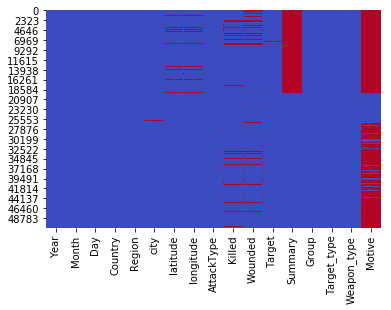

In [6]:
# Finding missing values through seaborn
sns.heatmap(df.isnull(), cbar=False,cmap="coolwarm")

# 2. Pre-Processing
    2.1 Dealing with Missing Values
    2.2 Handling Categorical Data
    2.3 Handiling Imbalance data  
    2.4 Feature Selection
    2.5 Dimensionality Reduction (PCA)
    2.6 Scaling Data (My Research - Data Normalization Techniques)  ** is in the last section



## 2.1 Dealing with Missing Values
     - From this given heatmap we can observed that
        a) In city colums some datas are missing.
        b) Latitude and Longitude some datas are misssing but we are not going to use location as features.
        c) Killed and Wounded some data is lost, We can get this data based on realation between attackType.
        d) Target is not as importent feature 
        e) Summary and Motive data is null more then 50% so we will drop this features.

### a. City Values is messing --> Let's analyze that

In [7]:
# Lost datas on the city features.
print(len(df[df['city'].isnull()]))
# total missing value based on this specific country.
print(df[df['city'].isnull()]['Country'].value_counts())

77
Afghanistan    75
Pakistan        2
Name: Country, dtype: int64


In [8]:
# all datas of null city -- It is observed that both has same GPS location on that location based city name is given.
df[(df['city'].isnull()) & (df['Country']=='Pakistan')]

,Year,Month,Day,Country,Region,city,latitude,longitude,AttackType,Killed,Wounded,Target,Summary,Group,Target_type,Weapon_type,Motive
22784,2008,11,3,Pakistan,South Asia,NaN,34.95262,72.331113,Unarmed Assault,5.0,0.0,Pakistani civilians,"11/03/2008: On Monday, in an unspecified locat...",Tehrik-i-Taliban Pakistan (TTP),Private Citizens & Property,Melee,Spying for US soldiers in the case of the kill...
24218,2010,3,10,Pakistan,South Asia,NaN,34.95262,72.331113,Unknown,2.0,0.0,Suspected U.S. spies,"03/10/2010: On Wednesday, in the North West Fr...",Taliban,Private Citizens & Property,Unknown,The motive of the attack was retaliation for s...


In [9]:
# Based on Latitude and Longitude the specific city name is given
df.loc[(df['city'].isnull()) & (df['Country']=='Pakistan') , ['city']] = "Khairabad"

In [10]:
# Filled Data Sucessfully
print(len(df[df['city'].isnull()]))

75


In [11]:
# City which is empty Unknown 
df.loc[(df['city'].isnull()) & (df['Country']=='Afghanistan') , ['city']] = "Unknown"

In [12]:
print(len(df[df['city'].isnull()]))

0


### b) Latitude and Longitude some datas are misssing but we are not going to use location as features.

### c) Killed and Wounded some data is lost, We can get this data based on realation between attackType.

In [13]:
# Missing values based on Killed over AttackType
names_datas=df[df['Killed'].isnull()]['AttackType'].value_counts().index.tolist()

In [14]:
# Attack Types
names_datas

['Bombing/Explosion',
 'Armed Assault',
 'Hostage Taking (Kidnapping)',
 'Unknown',
 'Facility/Infrastructure Attack',
 'Hostage Taking (Barricade Incident)',
 'Assassination',
 'Hijacking',
 'Unarmed Assault']

In [15]:
# types : killed or Wonded, AttackType is given in above list
def datafix_Killed_Wonded(types,AttackType):
    df.loc[(df['AttackType'] == AttackType) & (df[types].isnull()),[types]] = int(df[(df['AttackType'] == AttackType) & (df[types].notnull())][types].mean())


In [16]:
# based on attack type the mean of that is taken for killed and wounded
for i in names_datas:
    datafix_Killed_Wonded('Killed',i)
    datafix_Killed_Wonded('Wounded',i)

In [17]:
# Total count the data is null or not
print(len(df[df['Killed'].isnull()]))
print(len(df[df['Wounded'].isnull()]))

0
0


### d) Target is not as importent feature because it has all unique texts.

In [18]:
# We cannot pick target as a feature.
df['Target'].value_counts()

Civilians                                                            1679
Soldiers                                                             1398
Checkpoint                                                           1111
Unknown                                                              1033
Military Unit                                                         968
                                                                     ... 
driver                                                                  1
Town of San Martin de Loba                                              1
Mineral carrying train                                                  1
Major Tito Samson*                                                      1
The local leader of the ruling party was targeted in the bombing.       1
Name: Target, Length: 22212, dtype: int64

### e) Summary and Motive data is null more then 50% so we will drop this features. We will also drop unwanted features.

In [19]:
df_final = df[['Year','Month','Country','Region','AttackType','Killed','Wounded','Target_type','Weapon_type','Group']]

In [20]:
df_final.head()

,Year,Month,Country,Region,AttackType,Killed,Wounded,Target_type,Weapon_type,Group
0,1970,1,Philippines,Southeast Asia,Unknown,0.0,1.0,Military,Unknown,New People's Army (NPA)
1,1970,4,Philippines,Southeast Asia,Unknown,2.0,0.0,Military,Unknown,New People's Army (NPA)
2,1970,4,Turkey,Middle East & North Africa,Bombing/Explosion,0.0,0.0,Airports & Aircraft,Explosives,Palestinians
3,1970,5,Paraguay,South America,Assassination,1.0,1.0,Government (Diplomatic),Firearms,Palestinians
4,1970,6,United Kingdom,Western Europe,Armed Assault,5.0,2.0,Terrorists/Non-State Militia,Incendiary,Irish Republican Army (IRA)


## 2.2 Handling Categorical Data
    - So, final we have columns in categorical form so we will change into label form or one hot encoding form.
        a) Group into OrdinalEncoder because it is our label.
        b) The columns like Country, Region, AttackType, Target_type, Weapon_type into one hot encoding.

### a) Group into OrdinalEncoder because it is our label.

In [21]:
# calling the object of ordinalencoder class and dtype will be into int64 form
enc = OrdinalEncoder(dtype=np.int64)

In [22]:
# transforming and storing the data into group column into dataframe.
df_final['Group'] = enc.fit_transform(df[['Group']])

In [23]:
# display
df_final.head(2)

,Year,Month,Country,Region,AttackType,Killed,Wounded,Target_type,Weapon_type,Group
0,1970,1,Philippines,Southeast Asia,Unknown,0.0,1.0,Military,Unknown,13
1,1970,4,Philippines,Southeast Asia,Unknown,2.0,0.0,Military,Unknown,13


### b) The columns like Country, Region, AttackType, Target_type, Weapon_type into one hot encoding.

In [24]:
# calling the object of OneHotEncoder class and dtype will be into int64 form
ohe = OneHotEncoder(dtype=np.int64)
# transforming and storing the array into variable for all the columns.
country = ohe.fit_transform(df.Country.values.reshape(-1,1)).toarray()
Region = ohe.fit_transform(df.Region.values.reshape(-1,1)).toarray()
AttackType = ohe.fit_transform(df.AttackType.values.reshape(-1,1)).toarray()
Target_type = ohe.fit_transform(df.Target_type.values.reshape(-1,1)).toarray()
Weapon_type = ohe.fit_transform(df.Weapon_type.values.reshape(-1,1)).toarray()

In [25]:
# convert the array to data frame with the different columns name.
dfOneHot_country = pd.DataFrame(country, columns = ["country_"+str(int(i)) for i in range(country.shape[1])])
dfOneHot_region = pd.DataFrame(Region, columns = ["region_"+str(int(i)) for i in range(Region.shape[1])])
dfOneHot_attacktype = pd.DataFrame(AttackType, columns = ["AttackType_"+str(int(i)) for i in range(AttackType.shape[1])])
dfOneHot_targettype = pd.DataFrame(Target_type, columns = ["Target_type_"+str(int(i)) for i in range(Target_type.shape[1])])
dfOneHot_weapontype = pd.DataFrame(Weapon_type, columns = ["Weapon_type_"+str(int(i)) for i in range(Weapon_type.shape[1])])

In [26]:
# concate all into final dataframe.
df = pd.concat([df_final, dfOneHot_country,dfOneHot_region,dfOneHot_attacktype,dfOneHot_targettype,dfOneHot_weapontype], axis=1)

In [27]:
# droping inwanted columns because we have in the form of one-hot encoding
df.drop(['Country','Region','AttackType','Target_type','Weapon_type'],axis=1,inplace=True)

In [28]:
# display
df.head(1)

,Year,Month,Killed,Wounded,Group,country_0,country_1,country_2,country_3,country_4,...,Weapon_type_0,Weapon_type_1,Weapon_type_2,Weapon_type_3,Weapon_type_4,Weapon_type_5,Weapon_type_6,Weapon_type_7,Weapon_type_8,Weapon_type_9
0,1970,1,0.0,1.0,13,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [29]:
X = df.drop(['Group'],axis=1)
y = df['Group']

### 2.3 Handiling Imbalance data
    - In this all datas are balance because all features are either in 0 and 1 form.

### 2.4 Feature Selection
    - Universal Feature selection

In [30]:
selector = SelectPercentile(f_regression, percentile=25) 
selector.fit(X,y)

for n,s in zip(X.columns, selector.scores_): 
    print ("Score : ", s, " for feature ", n)

Score :  125.6106190920143  for feature  Year
Score :  0.6868400987678989  for feature  Month
Score :  5.877463613954703  for feature  Killed
Score :  0.26017728631632503  for feature  Wounded
Score :  20612.761839510164  for feature  country_0
Score :  1.277763907389984  for feature  country_1
Score :  0.14717557956695876  for feature  country_2
Score :  0.0959851110051098  for feature  country_3
Score :  0.2943577681631403  for feature  country_4
Score :  1.5769564945261927  for feature  country_5
Score :  7.6682927393627445  for feature  country_6
Score :  3.462692376025062  for feature  country_7
Score :  1.500047975211262  for feature  country_8
Score :  353.5244267122828  for feature  country_9
Score :  49.57921473267521  for feature  country_10
Score :  2254.235602851336  for feature  country_11
Score :  1.5782389044231837  for feature  country_12
Score :  1.2606836411908187  for feature  country_13
Score :  0.2943577681631403  for feature  country_14
Score :  2.4374349010721015

### 2.5 Dimensionality Reduction (PCA)
    - Checked with PCA I am getting only 34% accuracy after dimensionality reduction with KNN algorithm.

In [31]:
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X)

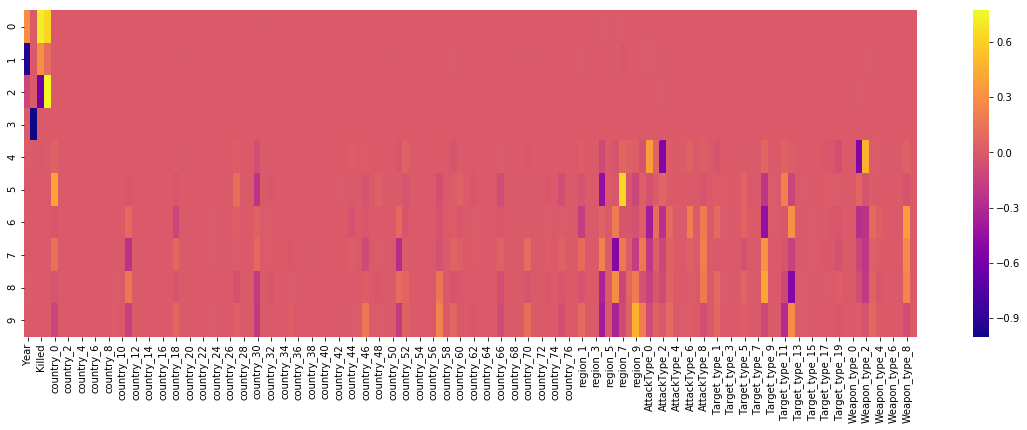

In [33]:
df_comp = pd.DataFrame(pca.components_,columns=X.columns)
plt.figure(figsize=(20,6))
sns.heatmap(df_comp,cmap='plasma')

### 2.6 Scaling Data (My Research - Data Normalization Techniques) 
    a) Min-Max Normalization
    b) Z-Score Normalization
    c) Max-ABS Normalization
    d) Median Normalization
    e) Sigmoid Normalization
    f) Tanh estimators

In [34]:
# a) Min-Max Normalization
scaler = MinMaxScaler()
X_MinMax = scaler.fit_transform(X_pca)

In [35]:
# b) Z-Score Normalization
stdscaler = StandardScaler()
X_Standard = stdscaler.fit_transform(X_pca)

In [36]:
# c) Max-ABS Normalization
X_MaxAbs = X_pca/X_pca.max(axis=0)

In [37]:
# d) Median Normalization
m = np.mean(X_pca, axis=0)
X_Median = X_pca / m

In [38]:
# e) Sigmoid Normalization
X_Sigmoid = 1/(1+np.exp(-X_pca))

In [39]:
# f) Tanh estimators
m = np.mean(X_pca, axis=0)
std = np.std(X_pca, axis=0)
X_Tanh = 0.5 * (np.tanh(0.01 * ((X_pca - m) / std)) + 1)

In [40]:
# g) Decimal Scaling Normalization - In our dataset this is not applicable because all datas are in the form of one hot encoding.

# 3) Model Selection
    3.1 LogisticRegression
    3.2 KNN
    3.3 Naive Bayes
    3.4 SVM (Support Vector Machine)
    3.5 Random Forest Classifier
    3.6 Decision Tree Classifier
    3.7 Ridge Complexity
    3.8 Stochastic Gradient Descent
    3.9 Multi-layer Perceptron
    
    Note: Based on maximum mean value, the top three model will be selected and normalization technique also.


In [41]:
def display_datas(lr,X,y,cv):
    # Training the model with the help of cross_val_score
    lr_score = cross_val_score(lr,X,y,cv=cv)
    # Mean and standard devation
    print (lr_score.mean(), lr_score.std())

### 3.1 LogisticRegression

In [42]:
# Logistic Regression model 
lr = LogisticRegression()

In [43]:
display_datas(lr,X_pca,y,3)

0.6363091528011685 0.05672155020703024


In [44]:
display_datas(lr,X_MinMax,y,3)

0.6005332814866224 0.02248354391000972


In [45]:
display_datas(lr,X_Standard,y,3)

0.6408107331586191 0.05860715703193896


In [46]:
display_datas(lr,X_MaxAbs,y,3)

0.6120413997824528 0.024995617915324363


In [47]:
display_datas(lr,X_Median,y,3)

0.5057056953038055 0.00347151811626605


In [48]:
display_datas(lr,X_Sigmoid,y,3)

0.601612287465214 0.04581195402301462


In [49]:
display_datas(lr,X_Tanh,y,3)

0.25459929836087375 0.021932523027818295


### 3.2 KNN

In [50]:
# KNN classfication model
knn = KNeighborsClassifier()

In [51]:
#Without Scaling
display_datas(knn,X_pca,y,3)

0.2551973273461121 0.02794894571610417


In [52]:
# MinMax
display_datas(knn,X_MinMax,y,3)

0.7396251545848213 0.02477742004271575


In [53]:
# Z score
display_datas(knn,X_Standard,y,3)

0.6955308653626262 0.02422966240937333


In [54]:
# Max abs
display_datas(knn,X_MaxAbs,y,3)

0.7315229137531097 0.026239141129036


In [55]:
# X median
display_datas(knn,X_Median,y,3)

0.6019821857393056 0.03525013185812474


In [56]:
# Sigmoid
display_datas(knn,X_Sigmoid,y,3)

0.5621554727441299 0.03972150548410778


In [57]:
# Tanh
display_datas(knn,X_Tanh,y,3)

0.6954917038196378 0.024232770124905482


### 3.3 Naive Bayes

In [58]:
# Gaussian Naive Bayes model
gnb = GaussianNB()

In [59]:
display_datas(gnb,X_pca,y,3)

0.49373129090600826 0.05687402059075443


In [60]:
display_datas(gnb,X_MinMax,y,3)

0.49373129090600826 0.05687402059075443


In [61]:
display_datas(gnb,X_Standard,y,3)

0.49373129090600826 0.05687402059075443


In [62]:
display_datas(gnb,X_MaxAbs,y,3)

0.49373129090600826 0.05687402059075443


In [63]:
display_datas(gnb,X_Median,y,3)

0.4937508561659327 0.05686022040114836


In [64]:
display_datas(gnb,X_Sigmoid,y,3)

0.5455085444269531 0.07491233371884229


In [65]:
display_datas(gnb,X_Tanh,y,3)

0.4962948868438451 0.056776718944808


### 3.4 SVM (Support Vector Machine)

In [66]:
# Support Vector Machine model
svm = SVC()

In [67]:
display_datas(svm,X_pca,y,3)

0.3110831721308161 0.07234252131305265


In [68]:
display_datas(svm,X_MinMax,y,3)

0.5950344070527431 0.02625998669830526


In [69]:
display_datas(svm,X_Standard,y,3)

0.7138520320396863 0.055439510455279464


In [70]:
display_datas(svm,X_MaxAbs,y,3)

0.6472321570780964 0.03479722347729289


In [71]:
display_datas(svm,X_Median,y,3)

0.14964289687698148 0.0009796588815018305


In [72]:
display_datas(svm,X_Sigmoid,y,3)

0.6045522401057604 0.056337142270162816


In [73]:
display_datas(svm,X_Tanh,y,3)

0.14635483253734374 2.514203637646004e-05


### 3.5 RandomForestClassifier

In [74]:
# Random forest model
rfc = RandomForestClassifier()

In [75]:
display_datas(rfc,X_pca,y,3)

0.7017756660373292 0.06409892062156033


In [76]:
display_datas(rfc,X_MinMax,y,3)

0.6898777374563458 0.05768380399913807


In [77]:
display_datas(rfc,X_Standard,y,3)

0.6989200410505593 0.0731821737554296


In [78]:
display_datas(rfc,X_MaxAbs,y,3)

0.6992728374477303 0.06869287410905005


In [79]:
display_datas(rfc,X_Median,y,3)

0.6959232264821527 0.07457844725282994


In [80]:
display_datas(rfc,X_Sigmoid,y,3)

0.6964116915978864 0.0727767098409615


In [81]:
display_datas(rfc,X_Tanh,y,3)

0.6961793662036712 0.0722984776422114


### 3.6 Decision Tree Classifier

In [82]:
# Decision Tree model
dtc = DecisionTreeClassifier()

In [83]:
display_datas(dtc,X_pca,y,3)

0.628375101827905 0.0839233293276891


In [84]:
display_datas(dtc,X_MinMax,y,3)

0.6332289613431775 0.08893187249338345


In [85]:
display_datas(dtc,X_Standard,y,3)

0.6282182969515532 0.09098356709847334


In [86]:
display_datas(dtc,X_MaxAbs,y,3)

0.6253599709757433 0.087607980588185


In [87]:
display_datas(dtc,X_Median,y,3)

0.6251455494451615 0.0826890356731863


In [88]:
display_datas(dtc,X_Sigmoid,y,3)

0.6449544989193384 0.09298339154620569


In [89]:
display_datas(dtc,X_Tanh,y,3)

0.6272786452004101 0.08873761476177096


### 3.7 Ridge Complexity

In [90]:
# Ridge classfication model
rcv = RidgeCV()

In [91]:
display_datas(rcv,X_pca,y,3)

0.5190534475167924 0.08957561944502487


In [92]:
display_datas(rcv,X_MinMax,y,3)

0.5185940656025826 0.08896630045276006


In [93]:
display_datas(rcv,X_Standard,y,3)

0.5190555095658985 0.0895382972303687


In [94]:
display_datas(rcv,X_MaxAbs,y,3)

0.5181111078572131 0.08661377869203943


In [95]:
display_datas(rcv,X_Median,y,3)

-7.380293844302722e+44 1.021903261358618e+45


In [96]:
display_datas(rcv,X_Sigmoid,y,3)

0.5250558249686282 0.08380748233022561


In [97]:
display_datas(rcv,X_Tanh,y,3)

0.5000325147832693 0.08220192950563665


### 3.8 Stochastic Gradient Descent

In [98]:
# Stochastic Gradient Descent model
sgdc = SGDClassifier()

In [99]:
display_datas(sgdc,X_pca,y,3)

0.3516294727275244 0.13417946430604571


In [100]:
display_datas(sgdc,X_MinMax,y,3)

0.5518943668049351 0.00724824764085758


In [101]:
display_datas(sgdc,X_Standard,y,3)

0.5890874410349817 0.042340737799275725


In [102]:
display_datas(sgdc,X_MaxAbs,y,3)

0.5477469179763758 0.011458124730312285


In [103]:
display_datas(sgdc,X_Median,y,3)

0.20072283586085501 0.0264100080262346


In [104]:
display_datas(sgdc,X_Sigmoid,y,3)

0.5932308871838906 0.01893107852272722


In [105]:
display_datas(sgdc,X_Tanh,y,3)

0.3399323952657503 0.09503913688989732


### 3.9 Multi-layer Perceptron

In [106]:
# Multi-layer Perceptron model
mlpc = MLPClassifier()

In [107]:
display_datas(mlpc,X_pca,y,3)

0.6623642304817374 0.09456930576928393


In [108]:
display_datas(mlpc,X_MinMax,y,3)

0.6989422750546473 0.09115128310887298


In [109]:
display_datas(mlpc,X_Standard,y,3)

0.7288466055373558 0.1032796844832077


In [110]:
display_datas(mlpc,X_MaxAbs,y,3)

0.7744443745790471 0.06681654752868177


In [111]:
display_datas(mlpc,X_Median,y,3)

0.6690168751433502 0.08354639093454466


In [112]:
display_datas(mlpc,X_Sigmoid,y,3)

0.6790392638468216 0.0633956871166358


In [113]:
display_datas(mlpc,X_Tanh,y,3)

0.5327335902033585 0.01267128383582966


# 4) Hyper Parameter Tuning

    - Based on above accuracy we pick best 3 accuracy including normalization.
    - Now, lets further explore to obtain more accuracy via hyper parameter tuning
    - picking the model and normalization method for Hyper Parameter Tuning.
    
    4.1) KNN - Min-Max - 0.73 
    4.2) Random Forest - Without Normalization -0.701
    4.3) SVM - Zscore - 0.71

### 4.1) KNN - Min-Max - 0.73

In [165]:
# list of range from 1 to 10
k_range = list(range(1, 10))
# weight options name
weight_options = ['uniform', 'distance']
# store into dictonary
param_grid = dict(n_neighbors=k_range, weights=weight_options,p=[2])
# GridSearchCV forms grid and check each parameaters.
# n_jobs -1 for alocating all resource for faster.
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, cv=10, scoring='accuracy',n_jobs=-1) 

In [166]:
# traning
grid_search.fit(X_MinMax, y)
# getting best score
print("Best Estimator {}".format(grid_search.best_estimator_))
print('Score {}'.format(grid_search.best_score_))

Best Estimator KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')
Score 0.8330169292494374


Text(87.0, 0.5, 'Predicated Value')

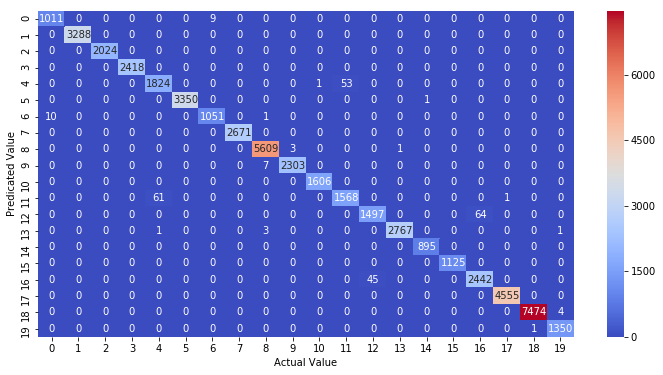

In [171]:
# For testing matrix is formed.
# plt.figure(figsize=(12,6))
# sns.heatmap(confusion_matrix(y,pred),cmap='coolwarm',annot=True,fmt="d")
# plt.xlabel('Actual Value')
# plt.ylabel('Predicated Value')

### 4.2) Random Forest - Without Normalization - 0.701
    - More hyper parmeater takes lots of time

In [178]:
# trees in random forest
n_estimators = [200, 205, 250]
# max_features type
max_features = ['auto', 'sqrt']
# samples for training each tree
bootstrap = [True, False]
# info dictonary
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'bootstrap': bootstrap}
# GridSearchCV forms grid and check each parameaters.
# n_jobs -1 for alocating all resource for faster.
grid_search = GridSearchCV(RandomForestClassifier(), param_grid=random_grid, cv=3, scoring='accuracy',n_jobs=-1) 

In [179]:
random_grid

{'n_estimators': [200, 205, 250],
 'max_features': ['auto', 'sqrt'],
 'bootstrap': [True, False]}

In [180]:
grid_search.fit(X_pca, y)

print("Best Estimator {}".format(grid_search.best_estimator_))
print('Score {}'.format(grid_search.best_score_))

Best Estimator RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Score 0.7213230257363734


### 4.3) SVM - Zscore - 0.71

In [184]:
# numbers of kernals
kernals = ['linear', 'poly', 'rbf', 'sigmoid']
Cs = [1.0,2.0,1.5,2.5]

# dictonary params
random_grid = {'kernel': kernals,
               'C': Cs,
                }


# GridSearchCV forms grid and check each parameaters.
# n_jobs -1 for alocating all resource for faster.
grid_search = GridSearchCV(SVC(), param_grid=random_grid, cv=3, scoring='accuracy',n_jobs=-1) 

In [189]:
random_grid

{'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'C': [1.0, 2.0, 1.5, 2.5]}

In [187]:
grid_search.fit(X_Standard, y)

print("Best Estimator {}".format(grid_search.best_estimator_))
print('Score {}'.format(grid_search.best_score_))

Best Estimator SVC(C=2.5, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Score 0.7429494079655543


In [188]:
grid_search.best_params_

{'C': 2.5, 'kernel': 'rbf'}

# EXIT